In [1]:
import numpy as np 
import matplotlib.pyplot as plt

# Problem 1: Quantum Eigenvalues in an Arbitrary Potential (Solving eigenvalue problems)

Consider the Energy-Eigenvalue equation of Quantum Mechanics in 1-dimension. 
\begin{equation}
    -\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2} + V(x)\psi = E\psi
\end{equation}

The added crinkle that makes this an eigenvalue problem is that we must find specifically those energies that satisfy the added boundary condition
\begin{equation}
    \lim_{x\to\pm\infty}\psi(x) = 0
\end{equation}

For our purposes, we will first construct a finite square well (FSW) potential of the form
\begin{equation}
    V(x) = \begin{cases}
        -V_0, & |x|\leq a \\
        0, & |x| \geq a
    \end{cases}
\end{equation}

# the Algorithm: ODE Solve + Search
1. Start on the very far left $x = -X_{max}\approx -\infty$, where $X_{max}>>a$. Because $V=0$ here, the analystic solution can be approximated to the asymptotic form $\psi(x)= e^{\pm kx}$. Accordingly, assume that the wavefuntion satisfies $\psi_{L}(-X_{max}) = e^{-kX_{max}}$. 

2. Use your favorite ODESolver to extend the solution until the "matching radius" $x_{match}$ which we might choose to be $x_{max}=+a$ here. 

3. Start at the other extreme $x=+X_{max}\approx\infty$ where our wavefunction can be assumed to satisfy $\psi_{R}(X_{max})=e^{-kX_{max}}$

4. Use your ODESolver to step $\psi_R(x)$ in toward the origin (to the left) from $x=+X_{max}$ unitil you reach the matching radius $x_{match}$. 

5. In order for probability to continuous and finite in a given range, we requre that both $\psi(x)$ and $\psi'(x)$ be continuous at the matching radius. This can be encapsulated in requiring the so-called *logarithmic derivative* $\psi'(x)/\psi(x)$ be continuous there.

6. Although we do not presuppose which values of $E$ are eigenvalues,we still need a starting value for the energy in order to use our ODE solver. Such being the case, we start the solution with a good guess for the energy. A good guess for the ground-state energy is a value slightly above the bottom of the well, e.g. $E_{gs} >-V_0$. 

7. Because it is unlikely that your guess is correct, the left and right wave functions will not be expected to match at $x_{match}$. Using the amount of *mismatch* as measured by the difference in logarithmic derative, we can come up with a correction: 
\begin{equation}
    \Delta(E, x) = \frac{\psi_L'(x)/\psi_L(x)-\psi_R'(x)/\psi_R(x)}{\psi_L'(x)/\psi_L(x)+\psi_R'(x)/\psi_R(x)}
\end{equation}
Where the denominator is included to avoid overly large/small. This measure gives us a way to intelligently form our next guess. We will continue the search unitl the left and right logarithmic derivative match to within some set tolerance. 

The Schrodinger energy-eigenvalue equation can be cast into two simultaneous ODE's as follows
\begin{align}
    \frac{d^2\psi}{dx^2} &= \frac{2m}{\hbar^2}\left(V(x)-E\right)\psi(x) \\ 
    &\Big\Downarrow \\ 
    \frac{d\phi^{(0)}}{dx} &= \phi^{(1)} \\ 
    \frac{d\phi^{(1)}}{dx} &= \frac{2m}{\hbar^2}(V(x)-E)\phi^{(0)}
\end{align}


In [67]:
# first, let us define the fourth order Runge-Kutta scheme so that 
# we can use it in our integration 

def rk4(t, h, N, y, f): # time, time_step, dimensions, L.H.S., R.H.S.
    k1, k2, k3, k4 = np.zeros([4, N])
    k1 = h*f(t,y)
    k2 = h*f(t+h/2, y+k1/2)
    k3 = h*f(t+h/2, y+k2/2) 
    k4 = h*f(t+h, y+k3) 
    y_new = y+(k1+2*(k2+k3)+k4)/6
    return y_new

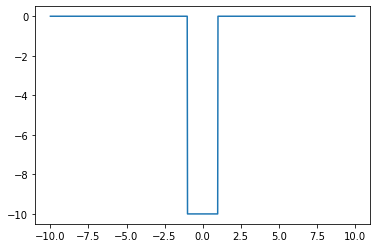

In [69]:
# Now define a function for the potential 

V0 = 10
L = 1 

def V(x): 
    Vout = np.ones_like(x) 
    Vout[np.abs(x)<=L] = -V0
    Vout[np.abs(x)>L] = 0
    
    return Vout
    
plt.figure() 
plt.plot(np.linspace(-10, 10, 1000), V(np.linspace(-10, 10, 1000)))
plt.show()

In [72]:
# now we define a function to represent hte R.H.S. of the Schrodinger ODE

m = 1 
hb = 1

def f(x, phi, E): 
    Phi = np.zeros((2), float)
    Phi[0] = phi[1] 
    Phi[1] = (2*m/(hb*hb))*(V(x)-E)*phi[0]
    return Phi

array([  1., -40.])

In [ ]:
# now we define how to compute the change in log derivative
def Delta(h, E): 
    Phi = np.zeros((2), float)
    